# **Отток Студентов**

## **Кратко о задаче:**
- *Необходимо построить модель оттока студентов*
- *Предлагаю свести это к задаче бинарной классификации, где 1 - студент будет отчислен, а 0 - студент не будет отчислен*
- *Данные не размечены, поэтому необходимо проанализировать и понять, в какой момент студент является отчисленым. А затем разметить по выявленным закономерностям*

## **Как бы я решал:**
#### **1. EDA, очистка данных, предварительный отбор фичей, **выделение таргета**: <br>**
- Здесь нужно точно понимать момент, когда студент считается отчисленным и правильно проставить метки таргета. *Например пользователь отчислен в 5-ом семестре, это значит что до этого момента мы должны проставить таргет этому студенту "не отчислен"*
- Также надо понимать, что у нас задача с дисбалансом классов и учитывать это в дальнейшем
#### **2. Генерация новых фичей. В качестве полезных фичей, которые я бы сгенерировал перед обучением модели:**
- курс
- семестр (например, для бакалавра от 1 до 8)
- средняя оценка студента за экзамены
- средняя оценка студента за предметы
- средняя оценка студента за последнюю сессию
- количество долгов
- среднее отклонение оценок студента
- средняя оценка по сложным предметам (выявить эти предметы в EDA)
- количество долгов по сложным предметам
- **! ВАЖНО: нельзя "заглядывать в будущее". Агрегации должны быть сделаны только из тех данных, которые мы как бы знаем на какой-то конкретный временной промежуток**
- было бы полезно еще учитывать посещаемость, но таких данных предоставлено не было

#### **3. Encoding категориальных фичей**
- Target encoding для специальности, например

#### **4. Агрегация данных для обучения**
- Кажется, что ситуация, когда 1 запись = информация по оценке студента по какому-то предмету в какой-то семестр не очень подходит для обучения
- Поэтому я бы агрегировал данные по студентам и семестрам. Получилось бы, что 1 запись = успеваемость какого-то студента за период начало обучения - какой-то семестр

#### **5. Метрики**
- Тут нужно понимать для чего мы строим модель. Нам важно на ранних этапах понимать, какие студенты в группе риска, и как-то быстро реагировать и стимулировать их. Подразумевается, что если студент попал в группу риска, у него не будет ужасных последствий
- Поэтому для таких целей нам нужно оптимизировать **recall**, ведь нам важнее как можно больше найти студентов, которые в группе риска.
- Точность имеет уже второе значение, но тоже важна, чтобы не маркировать слишком много студентов как находящихся в зоне риска отчисления, когда на самом деле они справляются хорошо.
- precision
- PR AUC - хороший выбор для несбалансированных классов
- **f1-мера с уклоном в recall - использовал бы для выбора модели** 

#### **6. Выбор модели**
- *Вполне веротяно, что задача может быть решена без ML-моделей, простым использованием каких-то эвристик*
- Линейная регрессия, Деревья: из плюсов хорошая интерпретируемость модели
- Random forest
- Catboost: вероятно покажет хорошее качество в данной задаче, а также есть autoencoder категориальных фичей
- ?Возможно попробовать перевести это в задачу прогнозирования временных рядов?

# Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/36/4qq8yw917gx9npbp0w2hv6t80000gn/T/ipykernel_53763/131226104.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
sns.set_style("whitegrid")

# Loading Data

In [3]:
df = pd.read_excel("data.xlsx")

In [4]:
df.head()

,hash,Номер ЛД,Уровень подготовки,Учебная группа,Специальность/направление,Учебный год,Полугодие,Дисциплина,Оценка (без пересдач),Оценка (успеваемость)
0,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Инженерная компьютерная графика,Хорошо,Хорошо
1,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Иностранный язык,Удовлетворительно,Удовлетворительно
2,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,История,зачтено,зачтено
3,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Математика,Хорошо,Хорошо
4,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Программирование и алгоритмизация,Хорошо,Хорошо


In [5]:
df = df.rename(columns={"Номер ЛД": "id",
                        "Уровень подготовки": "level",
                        "Учебная группа": "group",
                        "Специальность/направление": "speciality",
                        "Учебный год": "year", 
                        "Полугодие": "semester",
                        "Дисциплина": "subject",
                        "Оценка (без пересдач)": "grade",
                        "Оценка (успеваемость)": "perfomance"})
df.head(2)

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
0,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Инженерная компьютерная графика,Хорошо,Хорошо
1,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Иностранный язык,Удовлетворительно,Удовлетворительно


# EDA

Посмотрим пропуски в данных

In [6]:
print("Количество пропусков в данных по колонкам (проценты):")
round(df.isnull().sum() / len(df) * 100, 1).astype("str") + " %"

Количество пропусков в данных по колонкам (проценты):


hash           0.0 %
id             0.0 %
level          0.0 %
group          0.0 %
speciality     0.0 %
year           0.0 %
semester       0.0 %
subject        0.0 %
grade         49.7 %
perfomance    47.7 %
dtype: object

Колонки `grade` и `perfomance` имею почти по 50% пропущенных данных. Позже разберемся в чем дело

Взглянем на описательные статистики

In [7]:
df.describe(include="object")

,hash,level,group,speciality,year,semester,subject,grade,perfomance
count,376007,376007,376007,376007,376007,376007,376007,189004,196522
unique,9085,4,489,27,11,2,2096,9,9
top,002ed2297ad196e3b8a7e668f32d125b,Академический бакалавр,БЛГ-20-8,Лингвистика,2023 - 2024,II полугодие,Иностранный язык,Отлично,Отлично
freq,218,203074,3167,75400,158114,195820,30031,54506,57863


In [8]:
print(f"Количество студентов: \t {df.id.nunique()}")
print(f"Количество студентов: \t {df.group.nunique()}")

Количество студентов: 	 9098
Количество студентов: 	 489


In [9]:
df.grade.unique()

array(['Хорошо', 'Удовлетворительно', 'зачтено', nan, 'Отлично',
       'Неудовлетворительно', 'Неявка', 'не зачтено',
       'Неявка по ув.причине', 'Не допущен'], dtype=object)

In [10]:
df.perfomance.unique()

array(['Хорошо', 'Удовлетворительно', 'зачтено', 'Отлично', nan,
       'Неудовлетворительно', 'Неявка', 'не зачтено',
       'Неявка по ув.причине', 'Не допущен'], dtype=object)

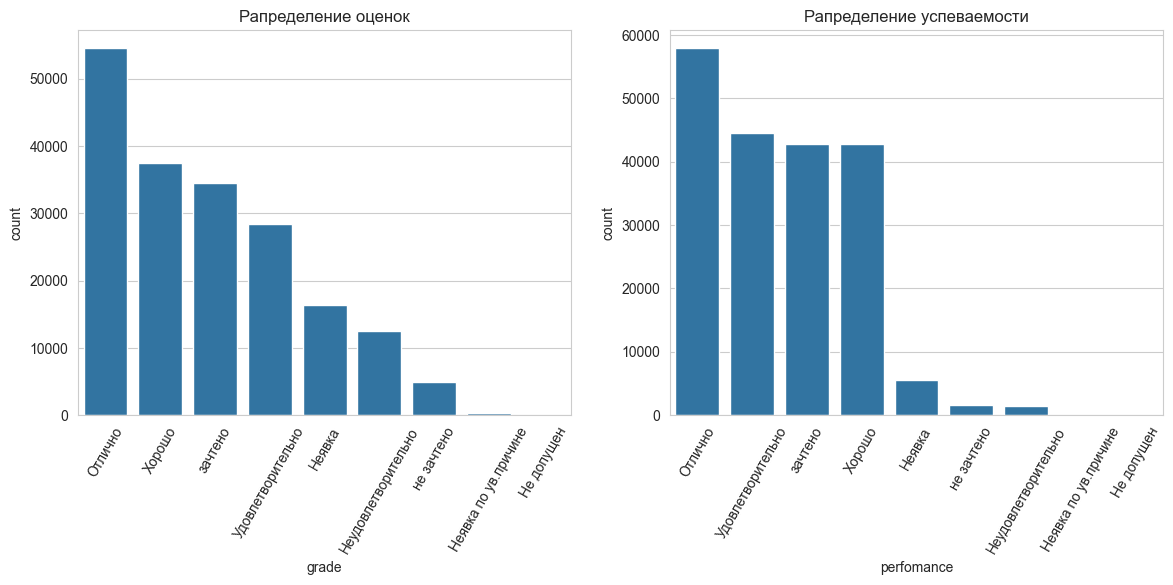

In [11]:
fig = plt.figure(figsize=(14, 5))

ax_1 = plt.subplot(1, 2, 1)

sns.barplot(df.grade.value_counts())

plt.title("Рапределение оценок")
plt.xticks(rotation=60)

ax_2 = plt.subplot(1, 2, 2)

sns.barplot(df.perfomance.value_counts())

plt.title("Рапределение успеваемости")
plt.xticks(rotation=60)

plt.show()

In [12]:
df.perfomance.value_counts()

perfomance
Отлично                 57863
Удовлетворительно       44577
зачтено                 42812
Хорошо                  42761
Неявка                   5504
не зачтено               1576
Неудовлетворительно      1419
Неявка по ув.причине        9
Не допущен                  1
Name: count, dtype: int64

У меня не было изначальной расшифровки колонок и условий, при которых студент считается отчисленым. Поэтому я буду считать, что: <br>
- `Оценка (без пересдач)` (grade) - оценка за экзамен
- `Оценка (успеваемость)` (perfomance) - итоговая оценка за предмет с учетом первой и второй пересдачи
- В `grade` спокойно может быть любая оценка, но вот, если в `perfomance` неуд, не зачтено или неявка, то студент считается отчисленным **P.S. В EDA -> Target поменял критерий**
- Небольшая ремарка по предыдущему пункту: последняя пересдача, как правило, примерно через год, соответсвенно, если в 2022 году, например, что-то не сдал, то он дальше может продолжить получать оценки по другим предметам, но как только он не сдает последнюю пересдачу (`perfomance`), студента отчисляют и дальше идут NaN

In [13]:
dismissed = df[df.perfomance.isin(["Неудовлетворительно", "не зачтено", "Неявка"])].id.nunique()
print(f'Получается, что каждый {round(df.id.nunique() / dismissed)}-ий студент отчислен')

Получается, что каждый 4-ий студент отчислен


Например, из группы в 24 человека, в конечном итоге будет отчислено приблизительно 8 человек - что в целом звучит примерно нормально, но возможно все же многовато

Возможно критерий отчисления не должна входить "Неявка", но кажется, что, если человек не появился на последней пересдаче, то он не сдал экзамен и соответсвенно отчислен.

*Этот момент требует уточнения.*

Также можем заметить, что факта неявки на пересдачи по предметам в 1.8 раз больше, чем незачетов + неудов. Вероятно, некоторые студенты в какой-то момент просто перестают появляться в вузе и на экзаменах - забрасывают универ

## Year

Поработаем с колонкой `year`

In [14]:
df.year.value_counts()

year
2023 - 2024    158114
2022 - 2023    113950
2021 - 2022     67558
2020 - 2021     28226
2019 - 2020      5520
2018 - 2019      2299
2024 - 2025       282
2025 - 2026        37
2017 - 2018        15
2026 - 2027         5
2027 - 2028         1
Name: count, dtype: int64

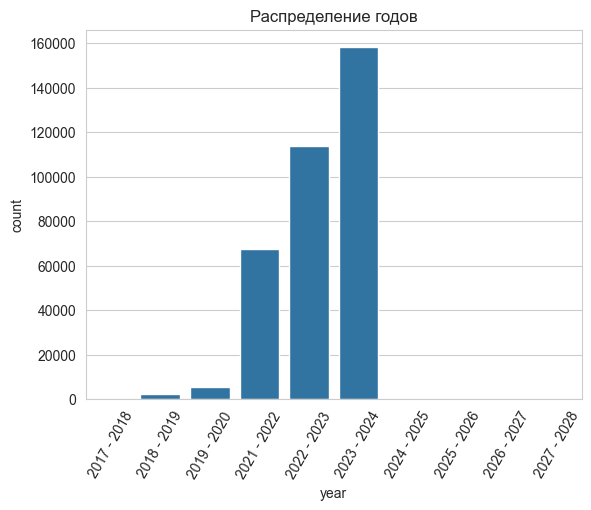

In [15]:
sns.barplot(df.year.value_counts(), order=["2017 - 2018", "2018 - 2019", "2019 - 2020", "2021 - 2022", "2022 - 2023", 
                                           "2023 - 2024", "2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])

plt.title("Распределение годов")
plt.xticks(rotation=60)

plt.show()

Странно, что есть какие-то данные за период 2024 - 2028. Посмотрим в ручную на эти записи

Сначала взглянем на период 2023 - 2024 второе полугодие, потому что оценок за этот период еще никаких не должно быть

In [16]:
print("Количество записей: " + str(df[(df.year == "2023 - 2024") & (df.semester == "II полугодие")].shape[0]))

df[(df.year == "2023 - 2024") & (df.semester == "II полугодие")].head()

Количество записей: 77317


,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
59,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2023 - 2024,II полугодие,Аппаратные средства хранения и обработки данных,NaN,NaN
60,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2023 - 2024,II полугодие,Информационная безопасность и кодирование,NaN,NaN
61,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2023 - 2024,II полугодие,Информационно-управляющие системы,NaN,NaN
62,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2023 - 2024,II полугодие,Курсовая научно-исследовательская работа,NaN,NaN
63,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2023 - 2024,II полугодие,Методы параллельной обработки данных,NaN,NaN


Посмотрим на количество пропусков в `grade` и `perfomance`

In [17]:
df[(df.year == "2023 - 2024") & (df.semester == "II полугодие")][["grade", "perfomance"]].isna().sum()

grade         76501
perfomance    76470
dtype: int64

Можем заметить, что в 99% случаях за 2023 - 2024 год второй семестр данные об оценках пропущены, что кажется логичным, ведь этот семестр только начался.

Сразу удалим данные, где `perfomance` и `grade` пропущены за семестр, который только начался

In [18]:
df = df[~((df.grade.isna())& (df.perfomance.isna()) & (df.year == "2023 - 2024") & (df.semester == "II полугодие"))]

Посмотрим на ненулевые записи в колонке `grade`

In [19]:
df[~(df.grade.isna()) & (df.year == "2023 - 2024") & (df.semester == "II полугодие")]

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
4092,f185715600a8147a4f5ab689320f432b,1909744,Академический бакалавр,БЭК-19-3з,Экономика,2023 - 2024,II полугодие,Анализ финансовой отчетности,зачтено,зачтено
4093,f185715600a8147a4f5ab689320f432b,1909744,Академический бакалавр,БЭК-19-3з,Экономика,2023 - 2024,II полугодие,Бюджет предприятия,Удовлетворительно,Удовлетворительно
4095,f185715600a8147a4f5ab689320f432b,1909744,Академический бакалавр,БЭК-19-3з,Экономика,2023 - 2024,II полугодие,Ключевые экономические показатели бизнеса,Удовлетворительно,Удовлетворительно
4096,f185715600a8147a4f5ab689320f432b,1909744,Академический бакалавр,БЭК-19-3з,Экономика,2023 - 2024,II полугодие,Налоги и налогообложение,Неудовлетворительно,Неудовлетворительно
4100,f185715600a8147a4f5ab689320f432b,1909744,Академический бакалавр,БЭК-19-3з,Экономика,2023 - 2024,II полугодие,Управление проектами,зачтено,зачтено
...,...,...,...,...,...,...,...,...,...,...
373383,8e3c7b5807d8efdc9b1f000dce40fcad,2112004,Специалист,СГД-21-6з,Горное дело,2023 - 2024,II полугодие,Геология,Неявка,Неявка
373384,8e3c7b5807d8efdc9b1f000dce40fcad,2112004,Специалист,СГД-21-6з,Горное дело,2023 - 2024,II полугодие,Горнопромышленная экология,Неявка,Неявка
373389,8e3c7b5807d8efdc9b1f000dce40fcad,2112004,Специалист,СГД-21-6з,Горное дело,2023 - 2024,II полугодие,Прикладная механика,не зачтено,не зачтено
373392,8e3c7b5807d8efdc9b1f000dce40fcad,2112004,Специалист,СГД-21-6з,Горное дело,2023 - 2024,II полугодие,Физика горных пород,Неявка,Неявка


Мне сложно объяснить природу этих данных. Возможно это какая-то досрочная сдача или что-то другое.

Пока что я удалю эти записи из данных.

In [20]:
df = df[~(~(df.grade.isna()) & (df.year == "2023 - 2024") & (df.semester == "II полугодие"))]

In [21]:
df[(~df.grade.isna()) & (df.perfomance.isna()) & (df.year == "2023 - 2024") & (df.semester == "II полугодие")]

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance


Объектов, чтобы не был пропущен `grade`, но был пропущен `perfomance` за этот период нет

Взглянем теперь на ненулевые записи в колонке `perfomance` за 2023 - 2024 год второй семестр

In [22]:
print(f'Количество строчек:                 {df[~(df.perfomance.isna()) & (df.year == "2023 - 2024") & (df.semester == "II полугодие")].shape[0]}')
print(f'Количество строчек с нулевым grade: {df[~(df.perfomance.isna()) & (df.year == "2023 - 2024") & (df.semester == "II полугодие")].grade.isna().sum()}')
print(f'Уникальные значения в perfomance:   {df[~(df.perfomance.isna()) & (df.year == "2023 - 2024") & (df.semester == "II полугодие")].perfomance.unique()}')

df[~(df.perfomance.isna()) & (df.year == "2023 - 2024") & (df.semester == "II полугодие")].head()

Количество строчек:                 371
Количество строчек с нулевым grade: 371
Уникальные значения в perfomance:   ['Хорошо' 'Удовлетворительно' 'Отлично' 'зачтено']


,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
1400,64a9281296895f40b84a42cd7d6a16d2,2214073,Специалист,СГД-19-1,Горное дело,2023 - 2024,II полугодие,Экономика и менеджмент горного производства,NaN,Хорошо
1524,4c59d0a09c826a3391721dc49555e2c1,2110542,Академический бакалавр,БПМ-21-2,Прикладная математика,2023 - 2024,II полугодие,Иностранный язык,NaN,Удовлетворительно
3195,e3deb7b8f8d0b49cc2f56cb17de2cb8c,2315545,Бакалавр,БИВТ-23-7,"Информатика и вычислительная техника (ИВТ, ИСТ...",2023 - 2024,II полугодие,Компьютерная и инженерная графика,NaN,Отлично
3196,e3deb7b8f8d0b49cc2f56cb17de2cb8c,2315545,Бакалавр,БИВТ-23-7,"Информатика и вычислительная техника (ИВТ, ИСТ...",2023 - 2024,II полугодие,Математика,NaN,Хорошо
3199,e3deb7b8f8d0b49cc2f56cb17de2cb8c,2315545,Бакалавр,БИВТ-23-7,"Информатика и вычислительная техника (ИВТ, ИСТ...",2023 - 2024,II полугодие,Персональная эффективность,NaN,зачтено


Вероятно, ситуации, когда в только начавшемся семестре у каких-то студентов уже есть оценки за предмет объясняются тем, что *студенты перевелись из другого университета и у них уже была успеваемость по этому предмету*

Можно заметить, что в таком случае успеваемость только положительная.

Есть гипотеза, что лучше все же удалить эти строчки перед обучением модели, но пока что пусть будут

Рассмотрим случаи, когда `year` 2024-2028

In [23]:
print(f'Количество строчек:                      {df[df.year.isin(["2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])].shape[0]}')
print(f'Количество строчек с нулевым grade:      {df[df.year.isin(["2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])].grade.isna().sum()}')
print(f'Количество строчек с нулевым perfomance: {df[df.year.isin(["2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])].perfomance.isna().sum()}')
print(f'Уникальные значения в perfomance:        {df[df.year.isin(["2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])].perfomance.unique()}')

df[df.year.isin(["2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])].head()

Количество строчек:                      325
Количество строчек с нулевым grade:      227
Количество строчек с нулевым perfomance: 67
Уникальные значения в perfomance:        ['зачтено' 'Удовлетворительно' 'Хорошо' 'Отлично' nan]


,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
3202,e3deb7b8f8d0b49cc2f56cb17de2cb8c,2315545,Бакалавр,БИВТ-23-7,"Информатика и вычислительная техника (ИВТ, ИСТ...",2024 - 2025,I полугодие,Философия,NaN,зачтено
3203,e3deb7b8f8d0b49cc2f56cb17de2cb8c,2315545,Бакалавр,БИВТ-23-7,"Информатика и вычислительная техника (ИВТ, ИСТ...",2024 - 2025,II полугодие,Безопасность жизнедеятельности,NaN,зачтено
3204,e3deb7b8f8d0b49cc2f56cb17de2cb8c,2315545,Бакалавр,БИВТ-23-7,"Информатика и вычислительная техника (ИВТ, ИСТ...",2024 - 2025,II полугодие,Цифровая экономика и процессное управление пре...,NaN,зачтено
3945,95e9475faa445fbac38fb41ea9611e9b,2105839,Академический бакалавр,БИВТ-21-16,Информатика и вычислительная техника,2024 - 2025,II полугодие,Философия,NaN,зачтено
4463,f32399a8744fa5bb51b8f75eb5a29f4a,2112213,Специалист,СГД-21-6з,Горное дело,2024 - 2025,II полугодие,Иностранный язык,NaN,Удовлетворительно


Можем заметить, что в 2024 - 2028 годах некоторые студенты так же имеют уже успеваемость по некоторым предметам и скорее всего это так же связано с переводом из другого вуза

In [24]:
df[(df.year.isin(["2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])) & (df.perfomance.isna())].head(2)

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
6155,f4e26c2bb9bdbbb9240818909d6293e8,1900386,Специалист,СГД-22-1,Горное дело,2024 - 2025,I полугодие,Метрология и стандартизация,не зачтено,NaN
6156,f4e26c2bb9bdbbb9240818909d6293e8,1900386,Специалист,СГД-22-1,Горное дело,2024 - 2025,I полугодие,Физика горных пород,Неявка,NaN


Есть ситуация, когда есть оценка за экзамен - `grade` но нет оценки итоговой - `perfomance`. Удалим такие случаи

In [25]:
df = df[~((df.year.isin(["2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])) & (df.perfomance.isna()))]

In [26]:
df[df.year.isin(["2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])].isna().sum()

hash            0
id              0
level           0
group           0
speciality      0
year            0
semester        0
subject         0
grade         227
perfomance      0
dtype: int64

In [27]:
df[df.perfomance.isna()].year.unique()

array(['2021 - 2022', '2023 - 2024', '2022 - 2023', '2020 - 2021',
       '2019 - 2020', '2018 - 2019', '2017 - 2018'], dtype=object)

In [28]:
print("Количество строчек: " + str(df[(df.perfomance.isna()) & (~df.year.isin(["2023 - 2024", "2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"]))].shape[0]))

df[(df.perfomance.isna()) & (~df.year.isin(["2023 - 2024", "2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"]))].head()

Количество строчек: 36728


,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
32,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2021 - 2022,II полугодие,Учебная практика,Неявка,NaN
239,d0e1ce9d5a808b346af5d278ddd6b616,2206374,Бакалавр,БМН-22-1,Менеджмент,2022 - 2023,II полугодие,Математика,Неудовлетворительно,NaN
515,7c59617378b8960a1a5d5de60b86a520,2001343,Академический бакалавр,БНМТ-21-1,Нанотехнологии и микросистемная техника,2022 - 2023,II полугодие,Методы математической физики,Неявка,NaN
516,7c59617378b8960a1a5d5de60b86a520,2001343,Академический бакалавр,БНМТ-21-1,Нанотехнологии и микросистемная техника,2022 - 2023,II полугодие,Основы квантовой механики и теория упругости,Неявка,NaN
518,7c59617378b8960a1a5d5de60b86a520,2001343,Академический бакалавр,БНМТ-21-1,Нанотехнологии и микросистемная техника,2022 - 2023,II полугодие,Учебная практика,NaN,NaN


In [29]:
df[(df.perfomance.isna()) & (~df.year.isin(["2023 - 2024", "2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"]))].head(2)

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
32,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2021 - 2022,II полугодие,Учебная практика,Неявка,NaN
239,d0e1ce9d5a808b346af5d278ddd6b616,2206374,Бакалавр,БМН-22-1,Менеджмент,2022 - 2023,II полугодие,Математика,Неудовлетворительно,NaN


Как я уже раньше упоминал, когда студент в `perfomance` получает фэйл, то дальше у него идут NaN. Поэтому данные пропущенны

Либо же это какие-то ошибки в данных

Удалим эти значения

In [30]:
df = df[~((df.perfomance.isna()) & (~df.year.isin(["2023 - 2024", "2024 - 2025", "2025 - 2026", "2026 - 2027", "2027 - 2028"])))]

In [31]:
df.perfomance.isna().sum()

66220

Но у нас все еще остались пропуски в данных в колонке с оценками

Посмотрим в какой временной промежуток это происходит:

In [32]:
print(df[df.perfomance.isna()].year.unique())
print(df[df.perfomance.isna()].semester.unique())

['2023 - 2024']
['I полугодие']


In [33]:
df[~(df.perfomance.isna()) & (df.year == "2023 - 2024")].head(3)

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
58,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2023 - 2024,I полугодие,Системы управления производством,зачтено,зачтено
68,953270dae24692e16c36eb91b1f2be7f,2311813,Бакалавр,БИВТ-23-9,"Информатика и вычислительная техника (ИВТ, ИСТ...",2023 - 2024,I полугодие,Введение в специальность,зачтено,зачтено
84,caad24c3877784fcfc2a76de142333aa,2305400,Магистр,МПИ-23-1-1,Прикладная информатика,2023 - 2024,I полугодие,Введение в искусственные нейронные сети,Отлично,Отлично


In [34]:
df[(df.perfomance.isna()) & (df.year == "2023 - 2024")].head(3)

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance
51,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2023 - 2024,I полугодие,CASE-технологии в управлении коллективом разра...,NaN,NaN
52,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2023 - 2024,I полугодие,Иностранный язык,NaN,NaN
53,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2023 - 2024,I полугодие,Интеллектуальный анализ данных,NaN,NaN


Есть гипотеза, что на момент, когда были выгружены данные, информация за 1 семестр 2023-2024 года по некоторым предметам еще не была получена

Например можем видеть студента с `id` = 2010218: по какому-то предмету у него уже стоит зачет, а по каким-то другим не стоит оценка

Удалим данные, где пропущен `perfomance`

In [35]:
df = df[~df.perfomance.isna()]

In [36]:
df.isna().sum()

hash              0
id                0
level             0
group             0
speciality        0
year              0
semester          0
subject           0
grade         15086
perfomance        0
dtype: int64

Таким образом, мы избавились от пропусков в `perfomance`. 

В `grade` же остались еще пропущенные значения, они возникают у переводников, у которых уже есть оценка по предмету в другом университете, и она просто переносится в `perfomance`, а никакой экзамен или зачем они не сдают.

## Target

Создадим колонку с таргетом

In [37]:
df.perfomance.apply(lambda x: 1 if x in ["Неудовлетворительно", "Неявка", "не зачтено"] else 0)

0         0
1         0
2         0
3         0
4         0
         ..
375975    0
375976    0
375979    0
375993    0
375997    0
Name: perfomance, Length: 196046, dtype: int64

In [38]:
df.loc[:, "dismissed"] = df.perfomance.apply(lambda x: 1 if x in ["Неудовлетворительно", "Неявка", "не зачтено"] else 0)
# df.loc[:, "dismissed"] = df.perfomance.apply(lambda x: 1 if x in ["Неудовлетворительно", "Неявка"] else 0)

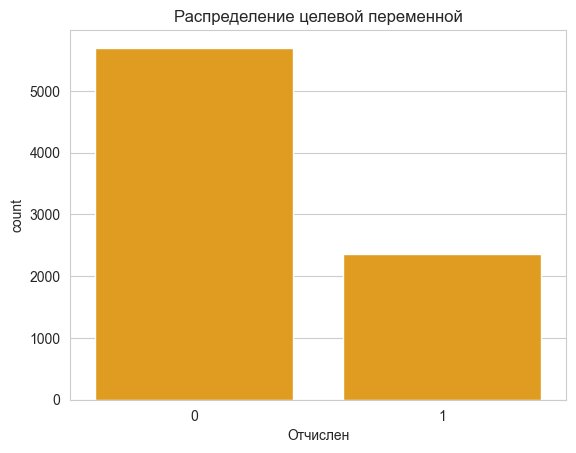

In [39]:
sns.barplot((df.groupby("id").dismissed.sum() >= 1).astype("int").value_counts(), color="orange")

plt.title("Распределение целевой переменной")
plt.xlabel("Отчислен")

plt.show()

Посчитаем группы, в которых чаще всего отчисляют

In [40]:
df[df.dismissed == 1].groupby(["group", "dismissed"]).id.nunique().sort_values(ascending=False)

group        dismissed
МИСТ-23-3-2  1            24
МИСТ-23-3-3  1            23
СГД-20-1     1            23
БИВТ-21-1    1            21
БНМТ-21-1    1            20
                          ..
БЭК-23-4     1             1
БЭК-23-5     1             1
БЭК-23-6     1             1
БИВТ-23-16   1             1
МЛГ-23-3     1             1
Name: id, Length: 331, dtype: int64

Рассмотрим группу **"МИСТ-23-3-2"**

Посчитаем количество учеников в группе

In [41]:
df[df.group == "МИСТ-23-3-2"].id.nunique()

26

Получается, что отчислили 24/26 студентов, что звучит очень нереалистично

In [42]:
df[df.group == "МИСТ-23-3-2"].head()

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance,dismissed
110267,b4daa46b300db35adf06510ce942b237,2311329,Магистр,МИСТ-23-3-2,Информационные системы и технологии,2023 - 2024,I полугодие,Frontend разработка,не зачтено,не зачтено,1
110272,b4daa46b300db35adf06510ce942b237,2311329,Магистр,МИСТ-23-3-2,Информационные системы и технологии,2023 - 2024,I полугодие,Основы теории и методологии дизайна,Отлично,Отлично,0
113327,717d0d254e1d7c908edcd8f336b2288b,2304449,Магистр,МИСТ-23-3-2,Информационные системы и технологии,2023 - 2024,I полугодие,Frontend разработка,не зачтено,не зачтено,1
113332,717d0d254e1d7c908edcd8f336b2288b,2304449,Магистр,МИСТ-23-3-2,Информационные системы и технологии,2023 - 2024,I полугодие,Основы теории и методологии дизайна,Неявка,Неявка,1
121061,434e61b82ddbc339bb4cb53f9d35bbc8,2313734,Магистр,МИСТ-23-3-2,Информационные системы и технологии,2023 - 2024,I полугодие,Frontend разработка,не зачтено,не зачтено,1


Можно заметить, что присутствуют не зачеты в `perfomance` у большого количества человек. Трудно понять с чем это связано.

**Думаю, что лучше пока что использовать критерий, что если в `perfomance` = "Неудовлетворительно" => студент отчислен**

In [43]:
df.loc[:, "dismissed"] = df.perfomance.apply(lambda x: 1 if x == "Неудовлетворительно" else 0)

In [44]:
df[df.dismissed == 1].groupby(["group", "dismissed"]).id.nunique().sort_values(ascending=False)

group      dismissed
СГД-20-1   1            16
БПИ-21-3   1            15
БМН-20-3   1            15
БПИ-20-2   1            13
БПИ-20-1   1            13
                        ..
БЛГ-20-6   1             1
БЛГ-20-16  1             1
МПИ-22-3   1             1
БЛГ-22-1   1             1
БПИ-22-7   1             1
Name: id, Length: 202, dtype: int64

In [45]:
df[df.group == "СГД-20-1"].id.nunique()

31

Теперь ситуация получше. Самое большое - 16/31 студентов было отчислено к 4-ому курсу 

Посмотрим распределение таргета

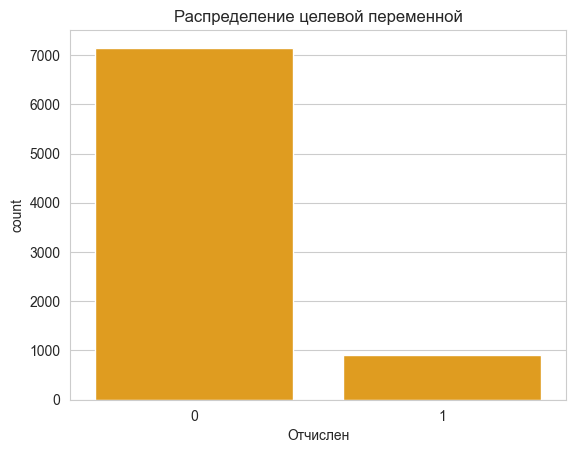

In [46]:
sns.barplot((df.groupby("id").dismissed.sum() >= 1).astype("int").value_counts(), color="orange")

plt.title("Распределение целевой переменной")
plt.xlabel("Отчислен")

plt.show()

In [47]:
dismissed = df[df.dismissed == 1].id.nunique()
students = df[df.dismissed == 0].id.nunique()

print(f'Получается, что каждый {round(students / dismissed)}-ий студент отчислен')

Получается, что каждый 9-ий студент отчислен


Преобразуем колонки с оценками в числовые значения

In [48]:
grades_mapping = {
    'зачтено': 6,
    'Отлично': 5,
    'Хорошо': 4,
    'Удовлетворительно': 3,
    'Неудовлетворительно': 2,
    'не зачтено': 0,
    'Неявка': -1,
    'Не допущен': -2,
    'Неявка по ув.причине': -3,
}

df["grade"] = df.grade.map(grades_mapping)
df["perfomance"] = df.perfomance.map(grades_mapping)

In [49]:
df.head(2)

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance,dismissed
0,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Инженерная компьютерная графика,4.0,4,0
1,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Иностранный язык,3.0,3,0


## Group

In [50]:
groupped_by_group = df[df.dismissed == 1].groupby("group", as_index=False) \
    .agg({"id": "nunique"}) \
    .rename(columns={"id": "dismissed"}) \
    .sort_values("dismissed", ascending=False) \
    .head(10)
groupped_by_group

,group,dismissed
187,СГД-20-1,16
104,БПИ-21-3,15
69,БМН-20-3,15
95,БПИ-20-2,13
93,БПИ-20-1,13
102,БПИ-21-1,13
68,БМН-20-2,13
126,БТМО-22-1,13
128,БФЗ-20-1,12
74,БМТ-20-1,12


In [51]:
groupped_by_group = groupped_by_group.merge(
    df[(df.dismissed == 0) & (df.group.isin(groupped_by_group.group.unique()))] \
        .groupby("group", as_index=False) \
        .agg({"id": "nunique"}) \
        .rename(columns={"id": "total"})
)
groupped_by_group.head()

,group,dismissed,total
0,СГД-20-1,16,31
1,БПИ-21-3,15,28
2,БМН-20-3,15,20
3,БПИ-20-2,13,23
4,БПИ-20-1,13,33


In [52]:
groupped_by_group_melted = pd.melt(groupped_by_group,
                                   id_vars=['group'], 
                                   value_vars=['dismissed', 'total'], 
                                   var_name='type', 
                                   value_name='count')
groupped_by_group_melted.head(1)

,group,type,count
0,СГД-20-1,dismissed,16


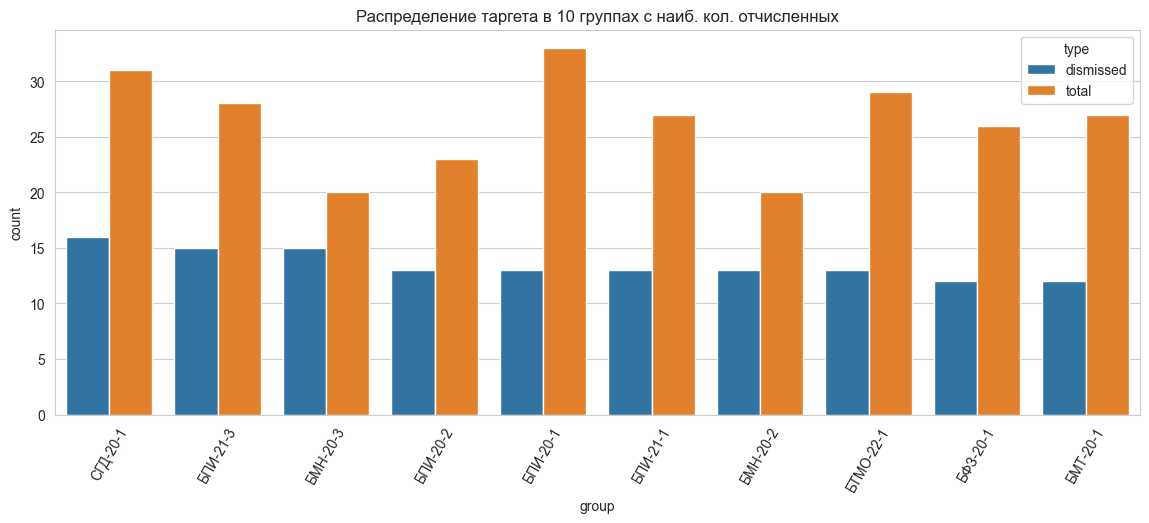

In [53]:
fig = plt.figure(figsize=(14, 5))

sns.barplot(data=groupped_by_group_melted, x="group", y="count", hue="type")

plt.title("Распределение таргета в 10 группах с наиб. кол. отчисленных")
plt.xticks(rotation=60)

plt.show()

Можем заметить, что отчислили больше всего в группах 3-4 курсов, что логично.

Для модели колонка `group` не будет полезна

## Speciality

Гипотеза: есть сложные специальности, на которых чаще отчисляют студентов

In [54]:
groupped_by_speciality = df[df.dismissed == 1].groupby("speciality", as_index=False) \
    .agg({"id": "nunique"}) \
    .rename(columns={"id": "dismissed"}) \
    .sort_values("dismissed", ascending=False) \

groupped_by_speciality = groupped_by_speciality.merge(
    df[(df.dismissed == 0) & (df.speciality.isin(groupped_by_speciality.speciality.unique()))] \
        .groupby("speciality", as_index=False) \
        .agg({"id": "nunique"}) \
        .rename(columns={"id": "total"})
)

groupped_by_speciality["dismissing_rate"] = round(groupped_by_speciality.dismissed / groupped_by_speciality.total, 2)

groupped_by_speciality = groupped_by_speciality.sort_values("dismissing_rate", ascending=False)

groupped_by_speciality.head(5)

,speciality,dismissed,total,dismissing_rate
4,Прикладная математика,73,309,0.24
2,Металлургия,96,449,0.21
0,Прикладная информатика,125,714,0.18
12,Физика,24,136,0.18
3,Бизнес-информатика,84,521,0.16


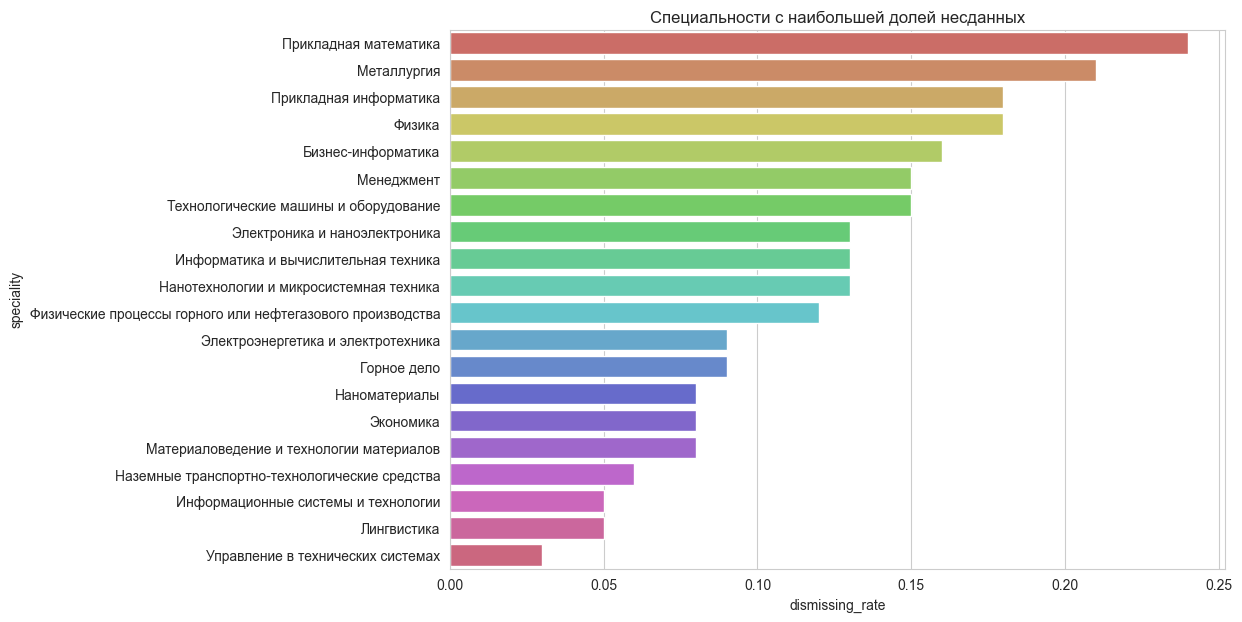

In [55]:
fig = plt.figure(figsize=(10, 7))

sns.barplot(data=groupped_by_speciality.head(20), x="dismissing_rate", y="speciality", palette="hls", hue="speciality", legend=False)

plt.title("Специальности с наибольшей долей несданных")

plt.show()

В самом деле, гипотеза подтвердилась. Самый большой процент отчисленных на "Прикладной математике" - почти 25%

Поэтому фича `speciality` может быть полезна для модели

## Subject

Гипотеза в том, что есть так же сложные предметы, на которых часто "валят" студентов

In [56]:
groupped_by_subject = df[df.dismissed == 1].groupby("subject", as_index=False) \
    .agg({"id": "nunique"}) \
    .rename(columns={"id": "dismissed"}) \
    .sort_values("dismissed", ascending=False) \

groupped_by_subject = groupped_by_subject.merge(
    df[(df.dismissed == 0) & (df.subject.isin(groupped_by_subject.subject.unique()))] \
        .groupby("subject", as_index=False) \
        .agg({"id": "nunique"}) \
        .rename(columns={"id": "total"})
)

groupped_by_subject["dismissing_rate"] = round(groupped_by_subject.dismissed / groupped_by_subject.total, 2)

groupped_by_subject = groupped_by_subject[groupped_by_subject.total > 50].sort_values("dismissing_rate", ascending=False)

groupped_by_subject.head(2)

,subject,dismissed,total,dismissing_rate
4,Эконометрика,43,156,0.28
3,Композиция,47,244,0.19


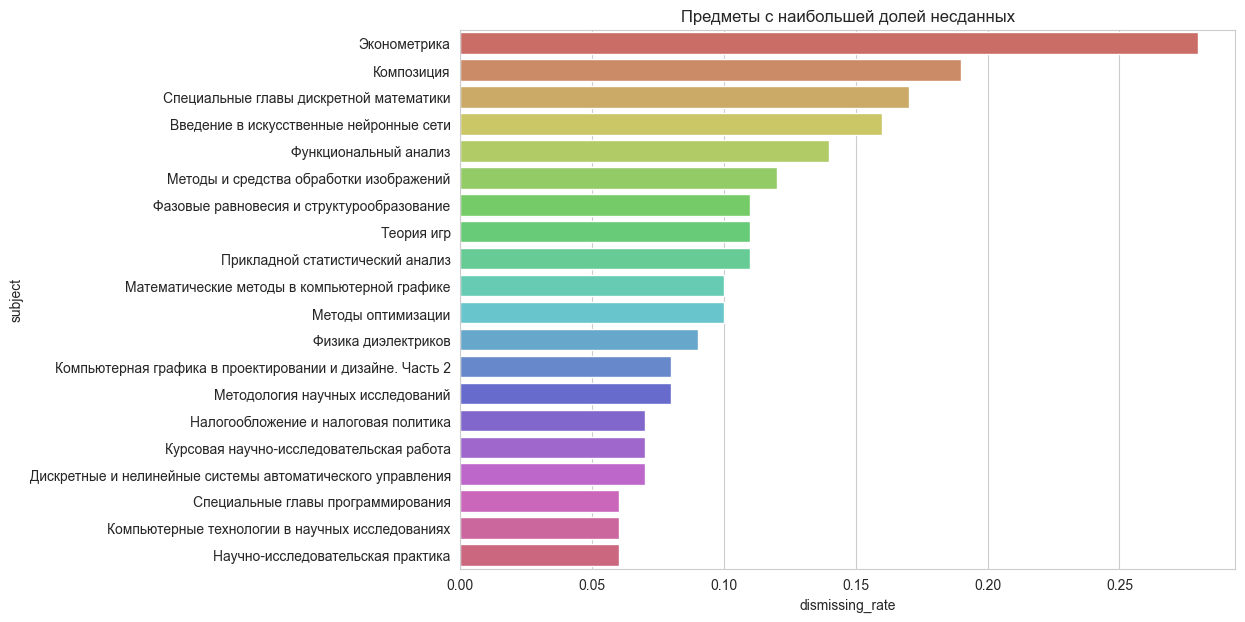

In [57]:
fig = plt.figure(figsize=(10, 7))

sns.barplot(data=groupped_by_subject.head(20), x="dismissing_rate", y="subject", palette="hls", hue="subject", legend=False)

plt.title("Предметы с наибольшей долей несданных")

plt.show()

В самом деле так и есть. Фича `subject` довольно полезная

# Feature Engineering

В качестве полезных фичей, которые я бы сгенерировал перед обучением модели:
- курс
- семестр (например, для бакалавра от 1 до 8)
- средняя оценка студента за экзамены, начиная с начала обучения и заканчивая текущим семестром
- средняя оценка студента за предметы, начиная с начала обучения и заканчивая текущим семестром
- средняя оценка студента за последнюю сессию
- количество долгов, начиная с начала обучения и заканчивая текущим семестром
- среднее отклонение оценок студента

In [58]:
df.head(2)

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance,dismissed
0,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Инженерная компьютерная графика,4.0,4,0
1,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Иностранный язык,3.0,3,0


Название групп содержит год, в котором эта группа начала обучение.

Например "БИВТ-20-4" значит, что студенты в 2020 - 2021 учебном году были на первом курсе.

**Создадим новую фичу - курс студента**

In [59]:
df.group.unique()

array(['БИВТ-20-4', 'БИВТ-23-9', 'МПИ-23-1-1', 'ББИ-20-3', 'БИВТ-23-8',
       'МПИ-23-4', 'БИВТ-22-9', 'БМН-22-1', 'ББИ-22-8', 'СГД-18-13',
       'ММТ-22-8', 'БЭЭ-23-1', 'БМТ-22-1', 'БТМО-22-1', 'БНМТ-21-1',
       'БМН-20-1', 'СГД-19-1', 'БПМ-20-4', 'МТМО-23-3', 'МУТС-23-1',
       'БМТМ-21-4', 'БЭН-22-2', 'БМН-21-2', 'МТБ-22-1', 'СГД-19-3',
       'ММТ-23-6', 'СГД-20-5', 'МЭЭ-22-2', 'МТМО-22-6', 'БПМ-21-2',
       'БПМ-22-1', 'БИВТ-21-4', 'БМТ-20-2', 'БМТ-22-2', 'БИВТ-22-10',
       'СГТ-23-1', 'БИВТ-22-5', 'МИВТ-22-5', 'БИВТ-21-3', 'ББИ-22-3',
       'ББИ-22-2', 'БЭН-23-2', 'БЭК-22-4', 'БЛГ-20-5', 'БЭК-20-3',
       'БЛГ-23-6', 'БИСТ-21-2', 'БМН-21-5', 'БЛГ-21-1', 'БЛГ-23-8',
       'БПИ-20-8', 'БПИ-20-3', 'БИСТ-20-2', 'БИВТ-23-11', 'БПИ-22-7',
       'ММТ-22-2', 'БИВТ-22-2', 'БИВТ-23-7', 'СГД-20-4', 'БЭК-22-3',
       'БПИ-21-4', 'БПИ-22-1', 'ББИ-21-3', 'ММТ-23-9', 'БФЗ-22-1',
       'ММТ-22-3', 'БИСТ-20-3', 'БМН-21-1', 'БИВТ-23-16', 'БПИ-22-5',
       'БИСТ-20-1', 'БПИ-22-6', 'Б

In [60]:
df.head(1)

,hash,id,level,group,speciality,year,semester,subject,grade,perfomance,dismissed
0,67a80fffd8d0294a596eda117d7e393c,2010218,Академический бакалавр,БИВТ-20-4,Информатика и вычислительная техника,2020 - 2021,I полугодие,Инженерная компьютерная графика,4.0,4,0


In [61]:
def parse_course(row):
    start_year = int("20" + row.group.split('-')[1])
    course = int(row.year.split("-")[1]) - start_year
    return course

In [62]:
df["course"] = df.apply(parse_course, axis=1).astype("int")

In [63]:
df = df[df.course <= 6]

In [64]:
def parse_semester(row):
    year_semester = 2 if row.semester[:2] == "II" else 1
    semester = 2 * row.course - (2 - year_semester)
    return semester

In [65]:
df.apply(parse_semester, axis=1).unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [66]:
df.loc[:, "semester"] = df.apply(parse_semester, axis=1)

In [67]:
df = df.drop(["group", "year", "hash"], axis=1)

In [68]:
df.head(2)

,id,level,speciality,semester,subject,grade,perfomance,dismissed,course
0,2010218,Академический бакалавр,Информатика и вычислительная техника,1,Инженерная компьютерная графика,4.0,4,0,1
1,2010218,Академический бакалавр,Информатика и вычислительная техника,1,Иностранный язык,3.0,3,0,1


Пока что приостановил решение